# ResNet-18 FewShot CNN Prototypical Classification

This notebook studies Few-Shot Learning using Prototypical Networks, which classifies images by measuring their distances to class prototypes and assigning images to the closest one. During meta-training, class prototypes are computed as the mean of the embeddings of support examples. This is useful for fine-grained classification and ensures robustness to noise in scenarios with limited data, by averaging across support samples.

Building on the final baseline model for ResNet18, the final FC layer is replaced with a linear projection and embeddings are L2-normalised. Episodic sampling with n-way k-shot episodes was used during training. During each episode, query samples are classified to class prototype with closest squared Euclidean distance, where the negative distances are passed to Cross Entropy Loss function. Validation episodes are evaluated every 20 episodes, with early stopping with patience of 10 epochs. After training, the best model is used to build K-shot prototypes (with K in [1, 3, 5]) from the train split. We then compute test accuracy using prototypical classification on the test split for each K.


## Imports and Reproducibility Setup 

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision import datasets, models
from torchvision.datasets import Flowers102
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.transforms import v2
from torch.utils.data import DataLoader, default_collate

import matplotlib.pyplot as plt
import random
import numpy as np
from itertools import product
import copy, time

from torch.utils.data import Dataset
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE

# For reproducibility
seed = 1001
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
rng = np.random.default_rng(seed)


## Data Preparation and Helper Functions

In [2]:
# Using best config from baseline model
BEST_LR = 5e-4
BEST_BATCH_SIZE = 32
BEST_DROPOUT = 0.3
BEST_WEIGHT_DECAY = 1e-04
BEST_PATIENCE = 5

NUM_CLASSES = 102

In [3]:
# resize images to 224x224 in line with ResNet input size, normalize images so mean and std are in line with pretrained statistics
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [4]:
# load the dataset
train_dataset = datasets.Flowers102(root='./data', split='train', download=True, transform=transform)
val_dataset = datasets.Flowers102(root='./data', split='val', download=True, transform=transform)
test_dataset = datasets.Flowers102(root='./data', split='test', download=True, transform=transform)

In [5]:
# create data loaders
# Use tuned batch size from baseline search

train_loader = DataLoader(train_dataset, batch_size=BEST_BATCH_SIZE, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_dataset,   batch_size=BEST_BATCH_SIZE, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset,  batch_size=BEST_BATCH_SIZE, shuffle=False, num_workers=2)

In [11]:
class EarlyStopper:
    def __init__(self, patience=5, min_delta=0.0, verbose=True, model_path='model.pth'):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf
        self.verbose = verbose
        self.model_path = model_path

    def early_stop(self, validation_loss, model):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0

            if self.model_path is not None:
                torch.save(model.state_dict(), self.model_path)
            return False

        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1

            if self.counter >= self.patience:
                if self.verbose:
                    print("Early stopping triggered.")
                return True

        return False


In [13]:
# Embedding Network & ProtoNet

class EmbeddingNet(nn.Module):
    """
    ResNet-18 (ImageNet pretrained) -> embedding -> L2-normalised.
    Used as backbone for Prototypical Network.
    """
    def __init__(self, embedding_dim=256):
        super().__init__()
        backbone = resnet18(weights=ResNet18_Weights.DEFAULT)
        # remove final FC
        self.features = nn.Sequential(*list(backbone.children())[:-1])
        self.fc = nn.Linear(backbone.fc.in_features, embedding_dim)

    def forward(self, x):
        x = self.features(x)          # (B, C, 1, 1)
        x = x.view(x.size(0), -1)     # (B, C)
        x = self.fc(x)                # (B, D)
        x = F.normalize(x, p=2, dim=1)
        return x


class ProtoNet(nn.Module):
    """
    Prototypical Network:
    Given support (x_s, y_s^epi) and query x_q:
    - Compute prototypes (mean embedding per episodic class)
    - Return distances from each query to all prototypes
    """
    def __init__(self, embedding_net: nn.Module):
        super().__init__()
        self.embedding_net = embedding_net

    def forward(self, support_images, support_labels_epi, query_images):
        z_support = self.embedding_net(support_images)   # (Ns, D)
        z_query   = self.embedding_net(query_images)     # (Nq, D)

        n_way = support_labels_epi.unique().numel()

        prototypes = []
        for c in range(n_way):
            mask = (support_labels_epi == c)
            proto = z_support[mask].mean(dim=0)
            prototypes.append(proto)
        prototypes = torch.stack(prototypes, dim=0)      # (n_way, D)

        # squared Euclidean distance
        # (B, n_way)
        distances = torch.cdist(z_query, prototypes, p=2) ** 2
        return distances


In [15]:
# Episodic Sampling Utilities

def build_label_index(dataset):
    """
    Build mapping class -> indices for episodic sampling.
    Uses dataset._labels from Flowers102.
    """
    labels_np = np.array(dataset._labels)
    idx_per_class = {}
    for idx, y in enumerate(labels_np):
        idx_per_class.setdefault(int(y), []).append(idx)
    return labels_np, idx_per_class

train_labels_np, train_idx_per_class = build_label_index(train_dataset)
val_labels_np,   val_idx_per_class   = build_label_index(val_dataset)
test_labels_np,  test_idx_per_class  = build_label_index(test_dataset)

def sample_episode(dataset, idx_per_class, n_way, k_shot, q_query):
    """
    Sample 1 n-way k-shot episode.
    Returns:
      support_images, support_labels_epi, query_images, query_labels_epi
    where episodic labels are in [0..n_way-1].
    """
    chosen_classes = random.sample(list(idx_per_class.keys()), n_way)

    support_indices = []
    query_indices = []
    epi_support = []
    epi_query = []

    for epi_label, cls in enumerate(chosen_classes):
        idxs = idx_per_class[cls]

        if len(idxs) < k_shot + q_query:
            idxs = np.random.choice(idxs, size=k_shot + q_query, replace=True)
        else:
            idxs = np.random.permutation(idxs)

        s_idx = idxs[:k_shot]
        q_idx = idxs[k_shot:k_shot + q_query]

        support_indices.extend(s_idx)
        query_indices.extend(q_idx)

        epi_support.extend([epi_label] * len(s_idx))
        epi_query.extend([epi_label] * len(q_idx))

    support_images = torch.stack([dataset[i][0] for i in support_indices], dim=0)
    query_images   = torch.stack([dataset[i][0] for i in query_indices], dim=0)

    support_labels_epi = torch.tensor(epi_support, dtype=torch.long)
    query_labels_epi   = torch.tensor(epi_query, dtype=torch.long)

    return support_images, support_labels_epi, query_images, query_labels_epi



# Training Loop for ProtoNet

In [17]:
# Train ProtoNet Episodically (Meta-Training)


def train_protonet(
    n_way=10,
    k_shot=5,
    q_query=5,
    num_episodes=400,
    val_interval=20,
    val_episodes=40,
    lr=BEST_LR,
    patience=10,
    model_path="protonet_best.pth"
):
    embedding_net = EmbeddingNet(embedding_dim=256)
    model = ProtoNet(embedding_net)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    stopper = EarlyStopper(patience=patience, min_delta=0.0,
                           verbose=True, model_path=None)

    train_loss_hist = []
    train_acc_hist = []
    val_loss_hist = []
    val_acc_hist = []
    val_checkpoints = []

    best_val_loss = np.inf
    best_val_acc = 0.0

    for episode in range(1, num_episodes + 1):
        model.train()

        # ----- sample train episode -----
        s_img, s_lab_epi, q_img, q_lab_epi = sample_episode(
            train_dataset, train_idx_per_class, n_way, k_shot, q_query
        )

        # forward on episode
        distances = model(s_img, s_lab_epi, q_img)
        loss = F.cross_entropy(-distances, q_lab_epi)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # training episodic accuracy
        preds = distances.argmin(dim=1)
        acc = (preds == q_lab_epi).float().mean().item()

        train_loss_hist.append(loss.item())
        train_acc_hist.append(acc)

        # ----- validation episodes -----
        if episode % val_interval == 0:
            model.eval()
            val_losses = []
            val_accs = []

            with torch.no_grad():
                for _ in range(val_episodes):
                    vs_img, vs_lab_epi, vq_img, vq_lab_epi = sample_episode(
                        val_dataset, val_idx_per_class, n_way, k_shot, q_query
                    )
                    vdist = model(vs_img, vs_lab_epi, vq_img)
                    vloss = F.cross_entropy(-vdist, vq_lab_epi)
                    vpred = vdist.argmin(dim=1)
                    vacc = (vpred == vq_lab_epi).float().mean().item()

                    val_losses.append(vloss.item())
                    val_accs.append(vacc)

            mean_vloss = float(np.mean(val_losses))
            mean_vacc = float(np.mean(val_accs))

            val_loss_hist.append(mean_vloss)
            val_acc_hist.append(mean_vacc)
            val_checkpoints.append(episode)

            print(
                f"[Episode {episode}/{num_episodes}] "
                f"Train Loss: {loss.item():.4f}, Train Acc: {acc:.4f} | "
                f"Val Loss: {mean_vloss:.4f}, Val Acc: {mean_vacc:.4f}"
            )

            # ---- early stopping + best model tracking (by val loss) ----
            improved = False
            if mean_vloss < best_val_loss - 1e-6:
                best_val_loss = mean_vloss
                best_val_acc = mean_vacc
                torch.save(model.embedding_net.state_dict(), model_path)
                improved = True

            if stopper.early_stop(mean_vloss, model.embedding_net):
                print("Early stopping ProtoNet training.")
                break

        else:
            # just log every 20 episodes for sanity
            if episode % 20 == 0:
                print(
                    f"[Episode {episode}/{num_episodes}] "
                    f"Train Loss: {loss.item():.4f}, Train Acc: {acc:.4f}"
                )

    # Load best embedding (from best val-loss checkpoint)
    best_embedding = EmbeddingNet(embedding_dim=256)
    best_embedding.load_state_dict(torch.load(model_path))
    best_model = ProtoNet(best_embedding)
    best_model.eval()

    history = {
        "train_loss": train_loss_hist,
        "train_acc": train_acc_hist,
        "val_loss": val_loss_hist,
        "val_acc": val_acc_hist,
        "val_episodes": val_checkpoints,
        "best_val_acc": best_val_acc,
        "model_path": model_path,
        "n_way_train": n_way,
        "k_shot_train": k_shot,
        "q_query": q_query,
    }

    print(f"\nBest ProtoNet episodic Val Acc: {best_val_acc:.4f}")
    return best_model, history


# -------- Run ProtoNet meta-training --------
protonet, proto_history = train_protonet(
    n_way=10,
    k_shot=5,
    q_query=5,
    num_episodes=400,
    val_interval=20,
    val_episodes=40,
    lr=BEST_LR,
    patience=10,
    model_path="protonet_best.pth"
)



[Episode 20/400] Train Loss: 1.0747, Train Acc: 0.9000 | Val Loss: 1.2957, Val Acc: 0.8135
[Episode 40/400] Train Loss: 0.9910, Train Acc: 0.9600 | Val Loss: 1.2438, Val Acc: 0.8405
[Episode 60/400] Train Loss: 0.8927, Train Acc: 1.0000 | Val Loss: 1.2301, Val Acc: 0.8590
[Episode 80/400] Train Loss: 0.8786, Train Acc: 1.0000 | Val Loss: 1.2192, Val Acc: 0.8400
[Episode 100/400] Train Loss: 0.8334, Train Acc: 1.0000 | Val Loss: 1.2109, Val Acc: 0.8680
[Episode 120/400] Train Loss: 0.8172, Train Acc: 1.0000 | Val Loss: 1.1735, Val Acc: 0.8840
[Episode 140/400] Train Loss: 0.8150, Train Acc: 1.0000 | Val Loss: 1.1794, Val Acc: 0.8930
[Episode 160/400] Train Loss: 0.8428, Train Acc: 1.0000 | Val Loss: 1.1973, Val Acc: 0.8725
[Episode 180/400] Train Loss: 0.7717, Train Acc: 1.0000 | Val Loss: 1.2057, Val Acc: 0.8695
[Episode 200/400] Train Loss: 0.7567, Train Acc: 1.0000 | Val Loss: 1.1736, Val Acc: 0.8625
[Episode 220/400] Train Loss: 0.7620, Train Acc: 1.0000 | Val Loss: 1.2063, Val Acc:

C:\Users\nguiy\AppData\Local\Temp\ipykernel_6012\977895900.py:109: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_embedding.load_state_dict(torch.load(model_path))


## Build K-shot Prototypes & Evaluate on Test Set

Here are the variants tested:
| K (Support Samples)      | 
|-----------------|
| 1   | 
| 2 |  
| 3 |

In [18]:
def build_few_shot_support(idx_per_class, K):
    """
    For each class, sample K support indices.
    """
    support = {}
    for cls, idxs in idx_per_class.items():
        idxs = np.array(idxs)
        if len(idxs) >= K:
            chosen = np.random.choice(idxs, size=K, replace=False)
        else:
            chosen = np.random.choice(idxs, size=K, replace=True)
        support[cls] = chosen.tolist()
    return support

@torch.no_grad()
def compute_prototypes(embedding_net, dataset, support_dict):
    """
    From support_dict[class] -> indices, compute mean embedding per class.
    """
    embedding_net.eval()
    prototypes = {}
    for cls, idxs in support_dict.items():
        imgs = torch.stack([dataset[i][0] for i in idxs], dim=0)  # (K, C, H, W)
        emb = embedding_net(imgs)                                 # (K, D)
        proto = emb.mean(dim=0)
        prototypes[cls] = proto
    return prototypes

@torch.no_grad()
def evaluate_with_prototypes(embedding_net, prototypes, loader):
    """
    Classify loader images by nearest prototype; return accuracy.
    """
    embedding_net.eval()
    class_ids = sorted(prototypes.keys())
    proto_mat = torch.stack([prototypes[c] for c in class_ids], dim=0)  # (C, D)

    correct = 0
    total = 0

    for imgs, labels in loader:
        emb = embedding_net(imgs)                               # (B, D)
        dists = torch.cdist(emb, proto_mat, p=2) ** 2          # (B, C)
        pred_idx = dists.argmin(dim=1)                         # proto index
        preds = torch.tensor(
            [class_ids[i] for i in pred_idx.cpu().tolist()],
            dtype=torch.long
        )

        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return correct / total if total > 0 else 0.0


K_values = [1, 3, 5]
few_shot_results = {}
best_val_acc_protonet = proto_history["best_val_acc"]

for K in K_values:
    support_dict = build_few_shot_support(train_idx_per_class, K)
    prototypes_K = compute_prototypes(protonet.embedding_net, train_dataset, support_dict)
    test_acc_K = evaluate_with_prototypes(protonet.embedding_net, prototypes_K, test_loader)

    few_shot_results[K] = {
        "support_indices": support_dict,
        "test_acc": test_acc_K,
        "best_val_acc": best_val_acc_protonet  # same ProtoNet checkpoint
    }

    print(f"K={K} per class -> Test Acc (ProtoNet Few-Shot): {test_acc_K:.4f}")



K=1 per class -> Test Acc (ProtoNet Few-Shot): 0.5872
K=3 per class -> Test Acc (ProtoNet Few-Shot): 0.5925
K=5 per class -> Test Acc (ProtoNet Few-Shot): 0.5970


## Data Visualisation and Plots

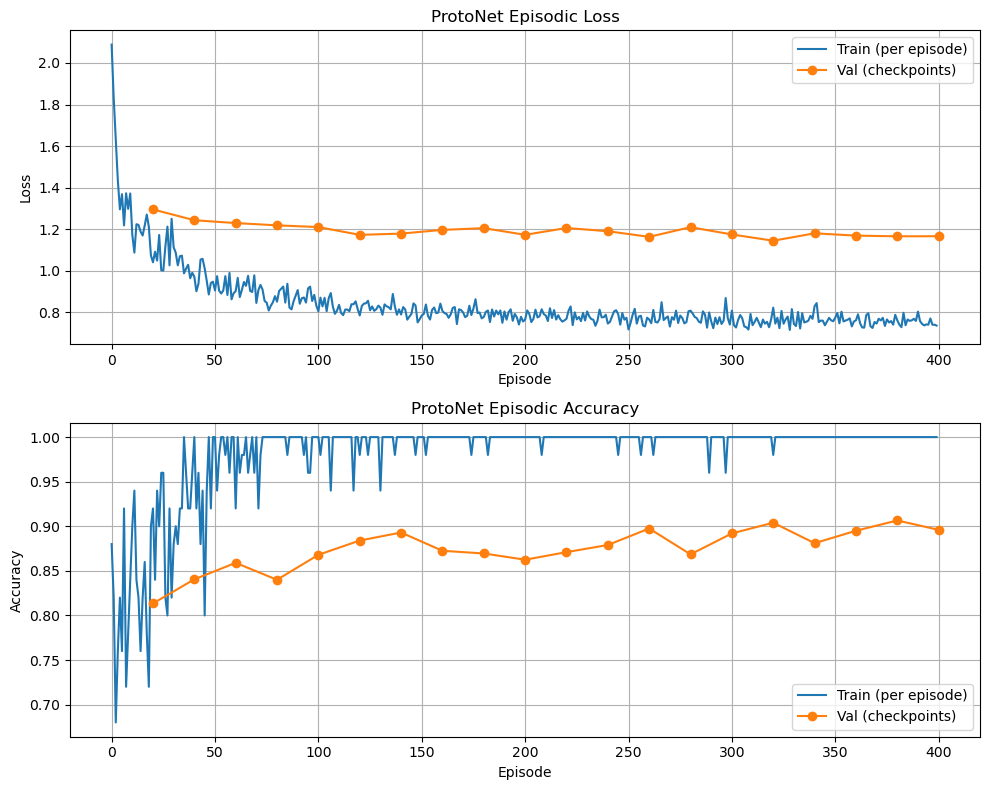

In [19]:
# Episodic training & validation curves

def plot_protonet_training(history):
    train_loss = history["train_loss"]
    train_acc = history["train_acc"]
    val_loss = history["val_loss"]
    val_acc = history["val_acc"]
    val_eps = history["val_episodes"]

    fig, axes = plt.subplots(2, 1, figsize=(10, 8))

    # Loss
    axes[0].plot(train_loss, label="Train (per episode)")
    if val_loss:
        axes[0].plot(val_eps, val_loss, "o-", label="Val (checkpoints)")
    axes[0].set_title("ProtoNet Episodic Loss")
    axes[0].set_xlabel("Episode")
    axes[0].set_ylabel("Loss")
    axes[0].grid(True)
    axes[0].legend()

    # Accuracy
    axes[1].plot([a for a in train_acc], label="Train (per episode)")
    if val_acc:
        axes[1].plot(val_eps, val_acc, "o-", label="Val (checkpoints)")
    axes[1].set_title("ProtoNet Episodic Accuracy")
    axes[1].set_xlabel("Episode")
    axes[1].set_ylabel("Accuracy")
    axes[1].grid(True)
    axes[1].legend()

    plt.tight_layout()
    plt.show()

plot_protonet_training(proto_history)


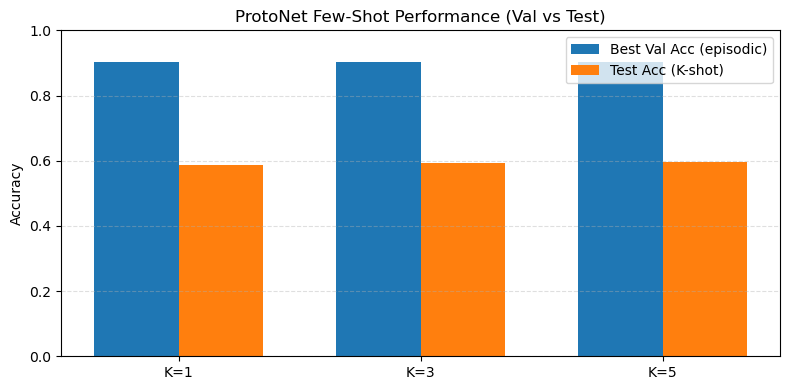

In [20]:
# K-shot bar: Best Val Acc vs Test Acc (to match other notebooks)

def plot_few_shot_bar_with_val(few_shot_results):
    Ks = sorted(few_shot_results.keys())
    labels = [f"K={K}" for K in Ks]
    val_scores = [few_shot_results[K]["best_val_acc"] for K in Ks]
    test_scores = [few_shot_results[K]["test_acc"] for K in Ks]

    x = np.arange(len(Ks))
    w = 0.35

    plt.figure(figsize=(8, 4))
    plt.bar(x - w/2, val_scores, width=w, label="Best Val Acc (episodic)")
    plt.bar(x + w/2, test_scores, width=w, label="Test Acc (K-shot)")
    plt.xticks(x, labels)
    plt.ylim(0.0, 1.0)
    plt.ylabel("Accuracy")
    plt.title("ProtoNet Few-Shot Performance (Val vs Test)")
    plt.grid(axis="y", linestyle="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_few_shot_bar_with_val(few_shot_results)


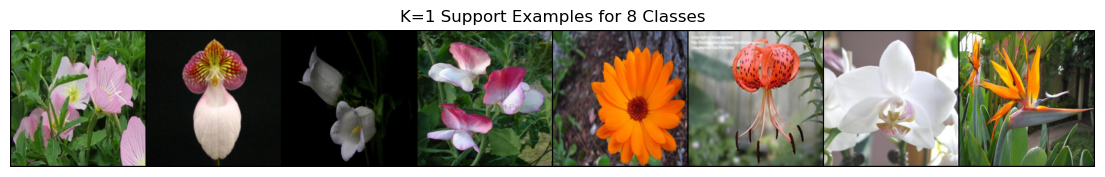

In [21]:
# Visualise K=1 support examples (like prototypes)

from torchvision.utils import make_grid

def visualize_support_examples_K1(train_dataset, support_dict, num_classes_to_show=8):
    chosen_classes = sorted(support_dict.keys())[:num_classes_to_show]
    imgs = []
    titles = []

    inv_mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    inv_std  = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

    for cls in chosen_classes:
        idx = support_dict[cls][0]
        img, _ = train_dataset[idx]
        x = img * inv_std + inv_mean
        x = torch.clamp(x, 0, 1)
        imgs.append(x)
        titles.append(str(cls))

    grid = make_grid(torch.stack(imgs, dim=0), nrow=num_classes_to_show)
    npimg = grid.numpy().transpose(1, 2, 0)

    plt.figure(figsize=(14, 3))
    plt.imshow(npimg)
    plt.axis("off")
    plt.title(f"K=1 Support Examples for {num_classes_to_show} Classes")
    plt.show()

visualize_support_examples_K1(train_dataset, few_shot_results[1]["support_indices"])

In [22]:
# Summary Printout 

print("\nProtoNet Few-Shot Summary (using best episodic checkpoint):")
for K in sorted(few_shot_results.keys()):
    r = few_shot_results[K]
    print(
        f"K={K:<2d} | "
        f"Best Val Acc (episodic): {r['best_val_acc']:.4f} | "
        f"Test Acc (K-shot ProtoNet): {r['test_acc']:.4f}"
    )


ProtoNet Few-Shot Summary (using best episodic checkpoint):
K=1  | Best Val Acc (episodic): 0.9040 | Test Acc (K-shot ProtoNet): 0.5872
K=3  | Best Val Acc (episodic): 0.9040 | Test Acc (K-shot ProtoNet): 0.5925
K=5  | Best Val Acc (episodic): 0.9040 | Test Acc (K-shot ProtoNet): 0.5970
